In [1]:
## Package and py file Imports ##
import os
import sys
sys.path.append("../PythonScripts/")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import synapseclient as sc
import warnings
import preprocessing_utils as prep
import utils

warnings.simplefilter("ignore")
sns.set_style("dark")

%matplotlib inline

Welcome, aryton tediarjo!



In [2]:
## acquire synapse object ##
syn = sc.login()

Welcome, aryton tediarjo!



In [3]:
## Acquire file entity from synapse and turn it into dataframes ##
entity = syn.get("syn21046180")
data   = pd.read_csv(entity["path"], index_col = 0)
data_for_pipeline = data.copy()

# I. Check Distribution of HealthCodes

From the previous studies, it is concluded that gender and age is a strong confounding factors towards the target variable of a patient having PD or not. Therefore, we would like to know if our data pipeline process does not alter the distribution of the healthcodes. An ideal healthcode would be to have an equal distribution of male PD and male nonPD as well as a equal healthcode of female PD vs female nonPD. 

As of age, an ideal case would be to have equal age distribution for male PD and male NONPD, and vice versa.

In [4]:
## helper function ## 
def plot_age_distribution(data):
    male_PD = data[(data["PD"] == 1) & (data["gender"] == "male")]["age"]
    male_NONPD = data[(data["PD"] == 0) & (data["gender"] == "male")]["age"]
    female_PD = data[(data["PD"] == 1) & (data["gender"] == "female")]["age"]
    female_NONPD = data[(data["PD"] == 0) & (data["gender"] == "female")]["age"]
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
    sns.distplot(male_PD, label = "PD", kde_kws={"shade": True}, hist = True, ax = axes[0])
    sns.distplot(male_NONPD, label = "NONPD", kde_kws={"shade": True}, hist = True, ax = axes[0])
    sns.distplot(female_PD, label = "PD", kde_kws={"shade": True}, hist = True, ax = axes[1])
    sns.distplot(female_NONPD, label = "NONPD", kde_kws={"shade": True}, hist = True, ax = axes[1])
    axes[0].grid()
    axes[0].set_title("Male Distribution")
    axes[1].grid()
    axes[1].set_title("Female Distribution")
    plt.legend()
    plt.show()
    
def plot_distribution(data):
    for i in [i for i in data.columns if "." in i]:
        PD = data[data["PD"] == True][i].dropna()
        NONPD = data[data["PD"] == False][i].dropna()
        fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
        sns.distplot(PD, label = "PD", kde_kws={"shade": True}, hist = False, ax = axes[0])
        sns.distplot(NONPD, label = "NONPD", kde_kws={"shade": True}, hist = False, ax = axes[0])
        sns.boxplot(x = "PD", y = i, data = data, ax = axes[1], orient = "v", order = [True, False])
        axes[0].set_title("p-values: {}".format(ttest_ind(PD, NONPD)[1]))
        axes[0].grid()
        axes[1].grid()
        plt.show()

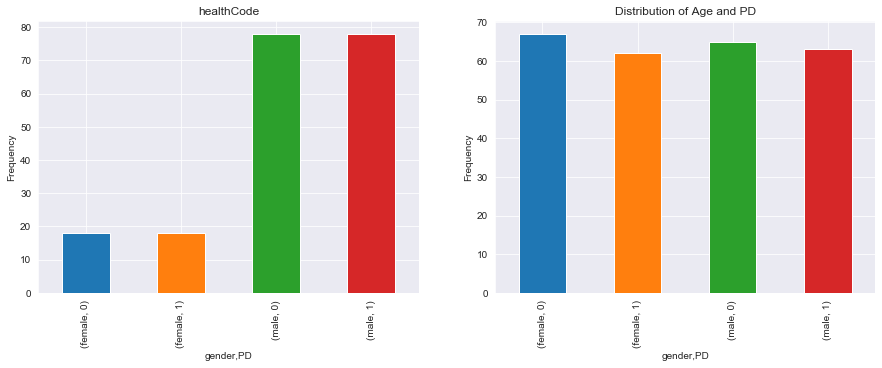

In [5]:
grouped = data.groupby(["gender", "PD"]).agg({"healthCode": lambda x: x.nunique(), "age": np.median})
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
grouped["healthCode"].plot(kind = "bar", ax = axes[0],subplots=True, grid = True, figsize = (15,10))
plt.title("Distribution of Genders and PD")
axes[0].set_ylabel("Frequency")
grouped["age"].plot(kind = "bar", ax = axes[1],subplots=True, grid = True, figsize=(15,10))
plt.title("Distribution of Age and PD")
plt.ylabel("Frequency")
plt.show()

The barplot above shows that the condition has been fulfilled, therefore the confounding effect of gender and age have been diminished. Now we will check the distribution of PD on each stratified gender if there is any significant difference between the two target classes on each stratified genders.

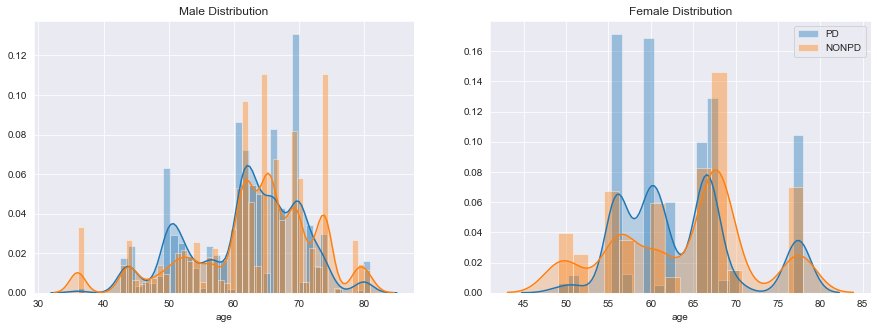

In [6]:
plot_age_distribution(data)

As the distribution is approximately the same (check p value later), we can proceed with the feature engineering process.

# II. Some Additional Features

Several additional features are added to the analysis for leveraging our predictive capabilities.

 - FC.no_of_steps = feature comination of number of steps in the xyz axis, by actually taking the resultant after PDKIT   calculation instead of the signal, as it has shown to be more representative of the number of steps actually done
 - freeze_occurences_per_sec = taken as freeze occurences that happen per second as the data collection is dependent on time due to different data collecting process in version 1 and version 2

In [7]:
## number of steps that is based on resultant steps, not based on the resultant signals ##
data["FC.no_of_steps"] = np.sqrt(data["x.no_of_steps"] ** 2 + \
                                    data["y.no_of_steps"] ** 2 + \
                                    data["z.no_of_steps"] ** 2)


## the speed of gait based on the resultant speed of gait of X,Y,and Z not based on the speed of 
## gait assessed from the resultant signals ##
data["FC.speed_of_gait"] = np.sqrt(data["x.speed_of_gait"] ** 2 + \
                                        data["y.speed_of_gait"] ** 2 + \
                                        data["z.speed_of_gait"] ** 2)


## per second basis features as mPower previous versions have discrepancies in recording data ##
data["FC.no_of_steps_per_sec"] = data["FC.no_of_steps"]/data["duration"]
data["x.freeze_occurences_per_sec"] = data["x.freeze_occurences"]/data["duration"]
data["y.freeze_occurences_per_sec"] = data["y.freeze_occurences"]/data["duration"]
data["z.freeze_occurences_per_sec"] = data["z.freeze_occurences"]/data["duration"]
data["AA.freeze_occurences_per_sec"] = data["AA.freeze_occurences"]/data["duration"]

## a).  Check Distributions between mean collapsed features

In [8]:
mean_data = prep.collapseFeatures(aggregation_type = "mean").transform(data)
# plot_distribution(mean_data)

## b). Check Distributions between max collapsed features

In [9]:
max_data = prep.collapseFeatures(aggregation_type = "max").transform(data)
# plot_distribution(max_data)

As noted from the distribution above, we observed that several features are able to detect signals between PD and NON-PD. However features like frequency of peaks are greatly skewed in both maximum and mean aggregation as there are some subject that can have a very high frequency of peaks, which can occur durin PD episodes or just by random chance; phone is shaking when tested on loose pants etc. Additionally other feature like stride and step regularity are highly skewed when collapsed by its maximum aggregation.

# III).  Feature Transformation and Preliminary Selection

- From the maximum collapsed plot of frequency of peaks, it is apparent the data is severely having outliers in the data, which will result in bias when put to ML models, especially to distance-based algo and boosting models.

- Therefore, from the data that we have, we will apply log-transformation to the data and see whether gaussian can be attained from it. 

In [10]:
max_data = prep.logTransformer(variables = [feat for feat in max_data if "frequency_of_peaks" in feat])\
                .transform(max_data)
mean_data = prep.logTransformer(variables = [feat for feat in mean_data if "frequency_of_peaks" in feat])\
                .transform(mean_data)

### a.) Log Transformed Frequency of Peaks

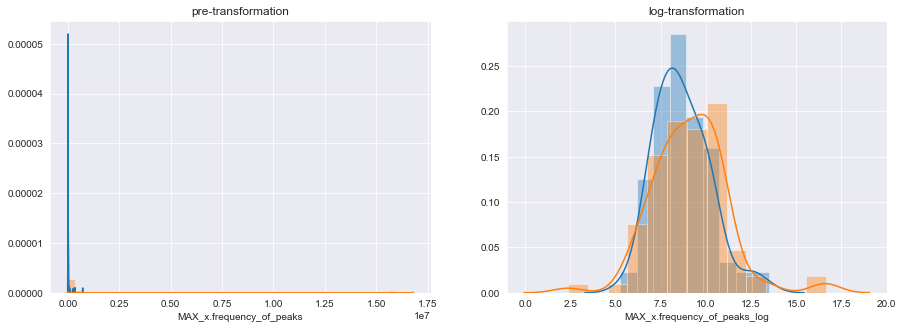

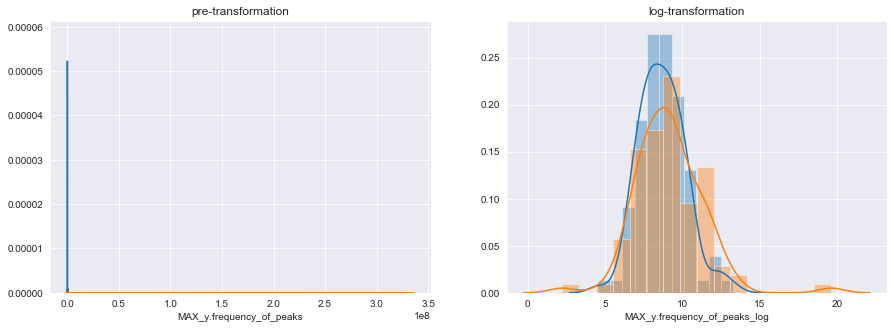

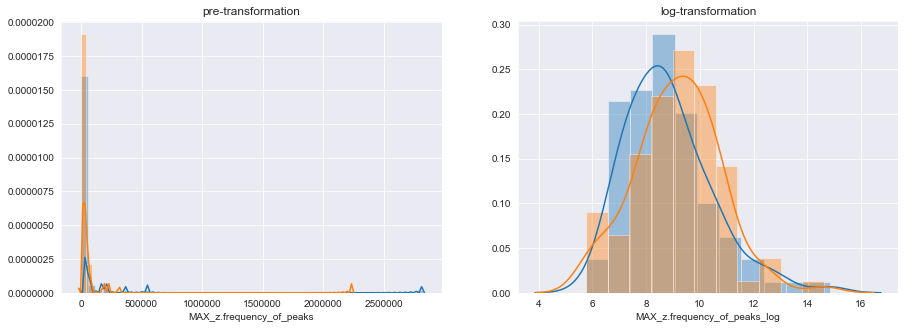

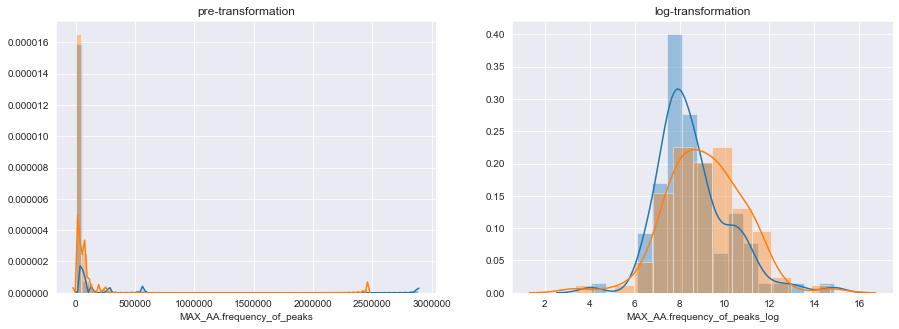

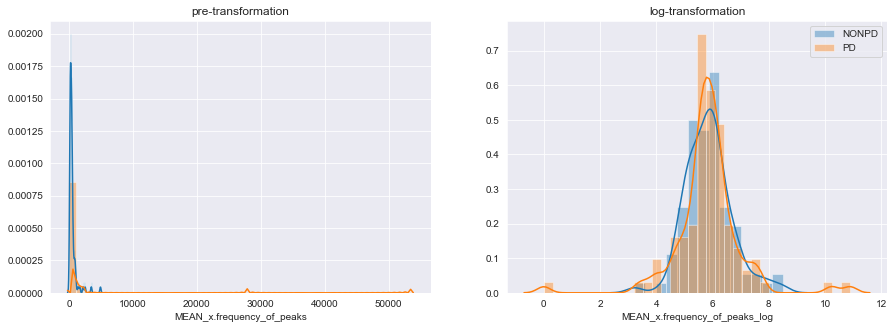

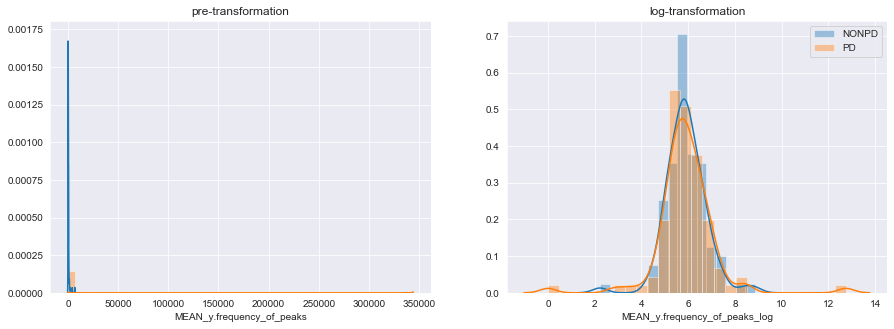

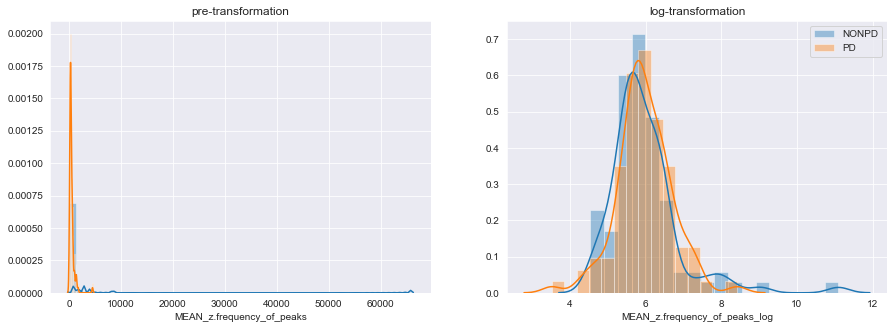

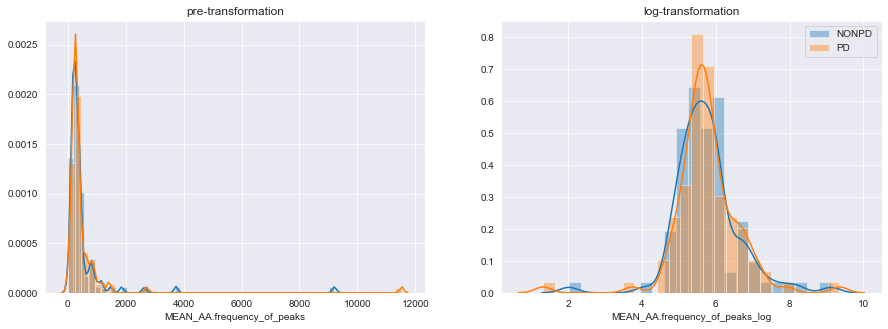

In [11]:
for coord in ["x", "y", "z", "AA"]:
    
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
    sns.distplot(max_data[max_data["PD"] == 0]["MAX_{}.frequency_of_peaks".format(coord)], label = "NONPD", ax = axes[0])
    sns.distplot(max_data[max_data["PD"] == 1]["MAX_{}.frequency_of_peaks".format(coord)], label = "PD", ax = axes[0])
    sns.distplot(max_data[max_data["PD"] == 0]["MAX_{}.frequency_of_peaks_log".format(coord)], label = "NONPD", ax = axes[1])
    sns.distplot(max_data[max_data["PD"] == 1]["MAX_{}.frequency_of_peaks_log".format(coord)], label = "PD", ax = axes[1])
    axes[0].grid()
    axes[0].set_title("pre-transformation")
    axes[1].set_title("log-transformation")
    axes[1].grid()
    plt.show()

for coord in ["x", "y", "z", "AA"]:
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
    sns.distplot(mean_data[mean_data["PD"] == 0]["MEAN_{}.frequency_of_peaks".format(coord)], label = "NONPD", ax = axes[0])
    sns.distplot(mean_data[mean_data["PD"] == 1]["MEAN_{}.frequency_of_peaks".format(coord)], label = "PD", ax = axes[0])
    sns.distplot(mean_data[mean_data["PD"] == 0]["MEAN_{}.frequency_of_peaks_log".format(coord)], label = "NONPD", ax = axes[1])
    sns.distplot(mean_data[mean_data["PD"] == 1]["MEAN_{}.frequency_of_peaks_log".format(coord)], label = "PD", ax = axes[1])
    plt.legend()
    axes[0].set_title("pre-transformation")
    axes[1].set_title("log-transformation")
    axes[0].grid()
    axes[1].grid()
    plt.show()

Using the log transformation, you can see that the data less prone to the outlier and is more interptretable for statistical inferences as it follows approximately a gaussian distribution. 

### b.) Stride Regularity

In [47]:
## WIP FOR NOW REMOVE